In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [18]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.dates as mdates

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import func, desc

In [20]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [21]:
# reflect an existing database into a new model
Base= automap_base()

# reflect the tables
Base.prepare(engine,reflect=True)

In [22]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [23]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [24]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [25]:
# Find the most recent date in the data set.
Date= Base.classes.measurement
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. # Calculate the date one year from the last date in data set.
#one_year_ago= most_recent_date - dt.timedelta(days=365)
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(one_year_ago)

2016-08-23


In [28]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

In [29]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
# Sort the dataframe by date
df = df.sort_values('Date')
print(df)

            Date  Precipitation
0     2016-08-23            0.0
1     2016-08-23            3.8
2     2016-08-23            1.3
3     2016-08-23            NaN
4     2016-08-23            0.5
...          ...            ...
2225  2017-08-22           12.7
2228  2017-08-23            2.0
2226  2017-08-23            0.0
2227  2017-08-23            0.0
2229  2017-08-23           11.4

[2230 rows x 2 columns]


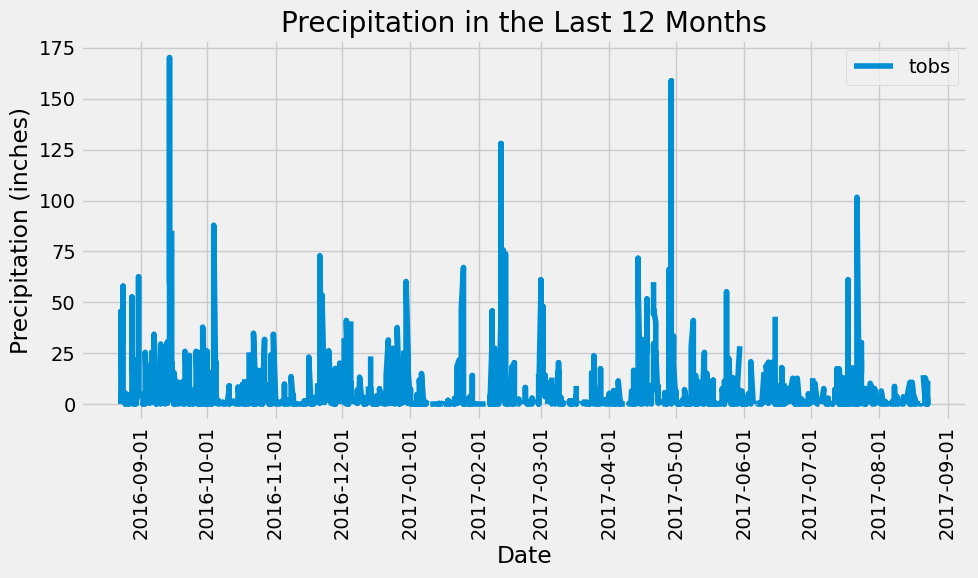

In [37]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
df['Date'] = pd.to_datetime(df['Date'])
plt.plot(df['Date'], df['Precipitation'],label="tobs")
plt.title('Precipitation in the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=90)
plt.legend (loc = "upper right")
plt.tight_layout()
plt.show()

In [38]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['Precipitation'].describe()
summary_stats

count    2021.000000
mean        4.505888
std        11.713487
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [40]:
# Design a query to calculate the total number of stations in the dataset
station_count= session.query(func.count(Station.station)).scalar()
station_count

9

In [46]:
most_active_st = session.query(Measurement.station).group_by(Measurement.station)\
    .order_by(func.count().desc())\
    .first()

    #define most recent date in data set
recent_date =  session.query(Measurement.date).order_by(Measurement.date.desc()).first()

results = session.query(Measurement.date, Measurement.tobs)\
        .filter(Measurement.station == most_active_st[0])\
        .filter(func.strftime("%Y-%m-%d", Measurement.date) >= recent_date - dt.timedelta(days=365))\
        .all()
tobs_list = []
for date, tobs in results:
            tobs_dict = {}
            tobs_dict["Date"] = date 
            tobs_dict["Temperature Obs"]= tobs
            tobs_list.append(tobs_dict)
return jsonify(tobs_list)
print(tobs_list)

TypeError: unsupported operand type(s) for -: 'Row' and 'datetime.timedelta'

In [ ]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()

# Print the stations and their counts in descending order
for station, count in station_activity:
    print(station,count)

In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_stats = Session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()

# Extract the results
lowest_temp = temperature_stats[0][0]
highest_temp = temperature_stats[0][1]
average_temp = temperature_stats[0][2]

# Print the results
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {average_temp}")

In [ ]:
# Identify the station with the greatest number of observations
most_active_station = Session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()[0]

# Calculate the date one year ago from the last date in the dataset
one_year_ago = Session.query(func.date(func.max(Measurement.date), "-1 year")).scalar()

# Query the previous 12 months of TOBS data for the identified station
temperature_data = Session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Create a DataFrame to store the temperature observations
df = pd.DataFrame(temperature_data, columns=["Temperature"])

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df["Temperature"], bins=12, alpha=0.7)
plt.title("Temperature Observation for Most Active Station (Last 12 Months)")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close Session

In [ ]:
# Close Session
Session.close()